In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision 
from torchvision import datasets,transforms
import shutil

In [2]:
base_dir = r'C:\Users\22789\Desktop\学校课程学习\路飞python\4weather'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

In [63]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\22789/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████████████████████████████████████████████████████████████████████████| 9.83M/9.83M [01:21<00:00, 126kB/s]


In [64]:
model

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [65]:
for param in model.features.parameters():
    param.requires_grad = False

In [66]:
inf = model.classifier[-1].out_features=4

In [67]:
inf

4

In [36]:
#model.fc = nn.Linear(inf,4)

In [68]:
model

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [70]:
opt = optim.Adam(model.classifier.parameters(),lr = 0.001)

In [71]:
loss_fn = nn.CrossEntropyLoss()

In [72]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(192),
    transforms.RandomHorizontalFlip(),#左右水平反转
    transforms.RandomRotation(0.2), #随机旋转
    transforms.ColorJitter(brightness=0.5),#改变明暗度
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

In [73]:
test_transform = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

In [74]:
train_ds = torchvision.datasets.ImageFolder(
        train_dir,
        transform = train_transform
)

In [75]:
test_ds = torchvision.datasets.ImageFolder(
    test_dir,
    transform = test_transform
)

In [76]:
batch = 20
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch,
    shuffle =True
)
test_dl = torch.utils.data.DataLoader(
    test_ds,batch_size = batch
)

In [77]:
from torch.optim import  lr_scheduler
lr_sc = lr_scheduler.StepLR(opt,step_size = 5,gamma=0.9)

In [78]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
model = model.to(device)

In [79]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
#     if epoch%5 == 0:
#         for p in opt.param_groups:
#             p['lr'] *= 0.5
    lr_sc.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                y_pred = torch.argmax(y_pred, dim=1)
                test_correct += (y_pred == y).sum().item()
                test_total += y.size(0)
                test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', (epoch+1), 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [80]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 30
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc=fit(epoch,model,train_dl,test_dl)
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  1 loss：  0.067 accuracy: 0.674 test_loss：  0.048 test_accuracy: 0.773
epoch:  2 loss：  0.02 accuracy: 0.871 test_loss：  0.02 test_accuracy: 0.862
epoch:  3 loss：  0.023 accuracy: 0.854 test_loss：  0.021 test_accuracy: 0.889
epoch:  4 loss：  0.018 accuracy: 0.884 test_loss：  0.015 test_accuracy: 0.916
epoch:  5 loss：  0.015 accuracy: 0.912 test_loss：  0.014 test_accuracy: 0.92
epoch:  6 loss：  0.015 accuracy: 0.899 test_loss：  0.011 test_accuracy: 0.933
epoch:  7 loss：  0.012 accuracy: 0.913 test_loss：  0.015 test_accuracy: 0.924
epoch:  8 loss：  0.014 accuracy: 0.901 test_loss：  0.012 test_accuracy: 0.929
epoch:  9 loss：  0.012 accuracy: 0.927 test_loss：  0.011 test_accuracy: 0.947
epoch:  10 loss：  0.008 accuracy: 0.944 test_loss：  0.01 test_accuracy: 0.951
epoch:  11 loss：  0.012 accuracy: 0.908 test_loss：  0.013 test_accuracy: 0.92
epoch:  12 loss：  0.008 accuracy: 0.939 test_loss：  0.009 test_accuracy: 0.938
epoch:  13 loss：  0.009 accuracy: 0.928 test_loss：  0.01 test_accu

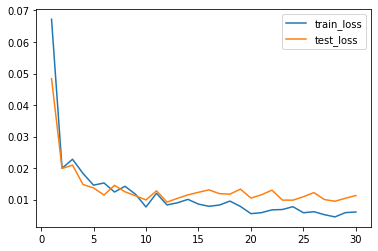

In [81]:
plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss')
plt.legend()

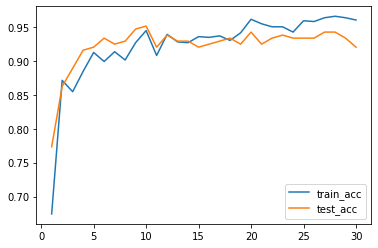

In [82]:
plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc')
plt.legend()

# 微调

In [83]:
for p in model.parameters():
    p.requires_grad = True

In [84]:
opt = optim.Adam(model.parameters(),lr=0.0001)

In [85]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 10
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc=fit(epoch,model,train_dl,test_dl)
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  1 loss：  0.004 accuracy: 0.978 test_loss：  0.009 test_accuracy: 0.947
epoch:  2 loss：  0.004 accuracy: 0.972 test_loss：  0.008 test_accuracy: 0.942
epoch:  3 loss：  0.003 accuracy: 0.981 test_loss：  0.008 test_accuracy: 0.956
epoch:  4 loss：  0.002 accuracy: 0.981 test_loss：  0.007 test_accuracy: 0.956
epoch:  5 loss：  0.002 accuracy: 0.989 test_loss：  0.008 test_accuracy: 0.942
epoch:  6 loss：  0.003 accuracy: 0.986 test_loss：  0.008 test_accuracy: 0.951
epoch:  7 loss：  0.003 accuracy: 0.976 test_loss：  0.009 test_accuracy: 0.942
epoch:  8 loss：  0.001 accuracy: 0.989 test_loss：  0.009 test_accuracy: 0.942
epoch:  9 loss：  0.002 accuracy: 0.988 test_loss：  0.011 test_accuracy: 0.929
epoch:  10 loss：  0.002 accuracy: 0.984 test_loss：  0.01 test_accuracy: 0.938
